# Language Knowledge (Vocabulary)
Duration: 30 minutes
Content: This section tests your knowledge of Japanese vocabulary, including kanji readings, orthography, word formation, contextually-defined expressions, paraphrases, and usage
It mainly composes following five categories:
- ``Reading Kana`` (Pronunciation Questions): Given a kanji word, choose the correct kana reading.
- `Writing Kanji` (Writing Questions): Given a word written in kana, choose the correct kanji representation.
- `Word Meaning` Selection (Vocabulary Understanding): Choose the most suitable word to fill in the sentence from four options.
- `Synonym Replacement`: Select a word that has the same or similar meaning as the underlined word.
- `Vocabulary Usage`: Assess the usage of words in actual contexts, choosing the most appropriate word usage, including some common Japanese expressions or fixed phrases.

In [ ]:
import pandas as pd
import json
import os
import pickle
import re
import uuid
from typing import *
from langchain_openai import AzureOpenAI,AzureChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
from dotenv import load_dotenv
from langchain_aws import ChatBedrock
from langchain.embeddings.base import Embeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.embeddings import HuggingFaceEmbeddings
# from langchain_community.embeddings import XinferenceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage,RemoveMessage,HumanMessage,AIMessage,ToolMessage
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List, Optional

load_dotenv()

True

In [ ]:
# Import N3 Vocabulary
file_path = '../Vocab/n3.csv'
# Read the CSV file
data = pd.read_csv(file_path)
words = data.iloc[:, :2].sample(frac=1).reset_index(drop=True)
# Display the content of the CSV file
words.head()

,expression,reading
0,下る,くだる
1,決心,けっしん
2,教わる,おそわる
3,胸,むね
4,松,まつ


#### load Models

In [ ]:
# azure_llm = AzureChatOpenAI(
#     azure_endpoint="https://tooldev-openai.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview",
#     api_key=os.environ["AZURE_API_KEY"],
#     model_name="gpt-4o",
#     api_version="2025-01-01-preview",
#     temperature=0.5,
# )

In [ ]:
aws_llm = ChatBedrock(
    model_id="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
     # model_id="us.anthropic.claude-3-5-haiku-20241022-v1:0",
    model_kwargs=dict(temperature=0.3),
    region = "us-east-2",
    aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
    aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
)

#### Exam Paper Outline
### A. overall thinking the structure of an exam
1. distribution of the difficulty 
2. topics
3. reasoning

In [ ]:
from typing import List, Optional

from langchain_core.prompts import ChatPromptTemplate

from pydantic import BaseModel, Field

instruction = """
Section 1: Vocabulary and Grammar
    SubSection: 
        - Kanji reading: 1-10 questions
        - Orthography: 1-10 questions
        - Word formation: 1-10 questions
        - Contextually-defined expressions: 1-10 questions
        - Paraphrases: 1-10 questions
        - Usage: 1-10 questions
        - Sentential grammar (Selecting grammar form): 1-10 questions
        - Sentential grammar (Sentence composition): 1-10 questions
        - Text grammar: 1-10 questions
Total Vocabulary and Grammar Questions: 25-35 questions

Section 2: Reading Comprehension
    SubSection:
        - Short passages: only 1 topic for 5-8 questions
        - Mid-size passages: only 1 topic for 4-6 questions
        - Long passages: only 1 topic for 3-5 questions
        - Information retrieval: only 1 topic for 3-5 questions
Total Reading Comprehension Questions: 15-24 questions

Section 3: Listening Comprehension
    SubSection:
        - Task-based comprehension: 5-8 questions
        - Comprehension of key points: 5-8 questions
        - Quick response: 5-8 questions
        - Integrated comprehension: 3-5 questions
Total Listening Comprehension Questions: 18-29 questions
"""

direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            f"You are a japanese teacher. Your job is to write an outline for a JLPT N3 level exam paper by randomly picking some of the topic list that user provided for different sections. The JLPT exam paper includes a mix of easy, moderate, and difficult questions to accurately assess the test-taker's proficiency across different aspects of the language."
            f"First, you should abide by the following exam instructions and decide content and number of questions in the each subsection."
            f"Second, the vocabulary should be restricted to N3 level, you can refer to the vocabulary in the word list"
            f"Finally, write the outline of the examination paper and provide question topics according to the instructions."
            f"instruction: {instruction}, word list: {words}",
        ),
        ("user", "topic list: {topic}"),
    ]
)


## Data Strcuture

In [ ]:
class QuestionTopic(BaseModel):
    question: str = Field(..., title="keyword of the question")
    
    
class Subsection(BaseModel):
    subsection_title: str = Field(..., title="Topic of the subsection")
    description: str = Field(..., title="giving the number of questions")
    question_topics: Optional[List[QuestionTopic]] = Field(
        default_factory=list,
        title="a number of questions according to the section requirements",
    )
    
    @property
    def as_str(self) -> str:
        question_topics_str = "\n".join(
            f"- **{qt.question}**" for qt in self.question_topics
        )
        return f"### {self.subsection_title}\n\n{self.description}\n\n{question_topics_str}".strip()

class Section(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    # description: str = Field(..., title="Ideas of this section")
    subsections: Optional[List[Subsection]] = Field(
        default_factory=list,
        title="Titles and reason for each subsection of the JLPT exam page.",
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            subsection.as_str for subsection in self.subsections or []
        )
        return f"## {self.section_title}\n\n{subsections}".strip()


class Outline(BaseModel):
    page_title: str = Field(..., title="Title of the JLPT exam page")
    sections: List[Section] = Field(
        default_factory=list,
        title="Titles and descriptions for each section of the JLPT exam paper.",
    )

    @property
    def as_str(self) -> str:
        sections = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()


In [ ]:
example_topic = """
Section 1 - Vocabulary and Grammar: 
店で価格を尋ねる | 購入したい商品の説明 | 割引交渉 | レストランで食べ物を注文する | 食事の好みについて話す | 料理を褒める | 道を尋ねる | 交通手段について話す | 交通状況について話す | タクシーを予約する | 電車の切符を買う | バスの時刻表を尋ねる | 通勤について説明する | 天気の状況について話す | 週末の予定について話す | おすすめを尋ねる | ショッピング体験を説明する | 支払い方法について話す | 領収書を求める | お気に入りのレストランについて話す | 趣味について話す | 仕事のプロジェクトについて話す | 家族について話す | 旅行の計画について話す | 最近の映画について話す | 本について話す | スポーツについて話す | 健康とフィットネスについて話す | 技術について話す | 時事問題について話す | 音楽について話す | 芸術と文化について話す | 教育について話す | キャリア目標について話す | 個人的な成果について話す | 課題と解決策について話す | 将来の抱負について話す | お気に入りのテレビ番組について話す | ペットについて話す | ガーデニングについて話す | 家の改善について話す | ファッションとスタイルについて話す | 環境問題について話す | ボランティア活動について話す | 地域のイベントについて話す
"""

generate_outline_direct = direct_gen_outline_prompt | azure_llm.with_structured_output(Outline)
initial_outline = generate_outline_direct.invoke({"topic": example_topic})

In [ ]:
from IPython.display import display, Markdown, Latex
display(Markdown(initial_outline.as_str))

# JLPT N3 Level Exam Paper

## Vocabulary and Grammar

### Kanji reading

5 questions

- **店で価格を尋ねる**
- **レストランで食べ物を注文する**
- **交通手段について話す**
- **天気の状況について話す**
- **趣味について話す**

### Orthography

3 questions

- **道を尋ねる**
- **バスの時刻表を尋ねる**
- **支払い方法について話す**

### Word formation

4 questions

- **購入したい商品の説明**
- **割引交渉**
- **料理を褒める**
- **電車の切符を買う**

### Contextually-defined expressions

3 questions

- **週末の予定について話す**
- **おすすめを尋ねる**
- **ショッピング体験を説明する**

### Usage

5 questions

- **仕事のプロジェクトについて話す**
- **家族について話す**
- **最近の映画について話す**
- **スポーツについて話す**
- **健康とフィットネスについて話す**

### Sentential grammar (Selecting grammar form)

5 questions

- **技術について話す**
- **時事問題について話す**
- **音楽について話す**
- **芸術と文化について話す**
- **教育について話す**

### Sentential grammar (Sentence composition)

4 questions

- **キャリア目標について話す**
- **個人的な成果について話す**
- **課題と解決策について話す**
- **将来の抱負について話す**

### Text grammar

4 questions

- **お気に入りのテレビ番組について話す**
- **ペットについて話す**
- **ガーデニングについて話す**
- **家の改善について話す**

## Reading Comprehension

### Short passages

5 questions

- **環境問題について話す**

### Mid-size passages

5 questions

- **ボランティア活動について話す**

### Long passages

3 questions

- **地域のイベントについて話す**

### Information retrieval

4 questions

- **お気に入りのレストランについて話す**

## Listening Comprehension

### Task-based comprehension

6 questions

- **レストランで食べ物を注文する**

### Comprehension of key points

6 questions

- **交通手段について話す**

### Quick response

5 questions

- **天気の状況について話す**

### Integrated comprehension

4 questions

- **週末の予定について話す**

# Kanji 读假名（读音问题）

     expression reading
0            下る     くだる
1            決心    けっしん
2           教わる    おそわる
3             胸      むね
4             松      まつ
...         ...     ...
2134         高価     こうか
2135        プラス     プラス
2136          旅      たび
2137         大使     たいし
2138       わがまま    わがまま

[2139 rows x 2 columns]


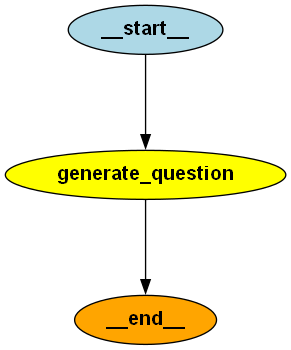

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class QuestionState(TypedDict):
    topic: str
    question: str
    improved_question: str
    final_question: str


kanji_example = """
1) いま 店の まえにいます。
1 いえ
2 えき
3 みせ
4 へや
2) たなかさんは いま 外国に います。
1 がいしゃ
2 かいしゃ
3 かいこく 4 がいこく
3) さとうさんは 話が じょうずです。
1 うた
2 はなし
3 え
4 じ
4) はやしさんも 読んで ください。
1 あそんで
2 ならんで
3 よんで
4 えらんで
5) あたらしい こうえんは まちの 北がわに あります。
1 ひがしがわ
2 みなみがわ
3 にしがわ
4 きたがわ
6) わたしは 九月に けっこんします。。
1 くがつ
2 きゅうがつ
3 くげつ
4 きゅうげつ
7) きのう 来なかった ひとは だれですか。
1 きなかった
2 こなかった
3 いなかった 
4 ねなかった
"""

print(words)

# Nodes
def generate_question(state: QuestionState):
    """First LLM call to generate initial question"""

    msg = llm.invoke(f"You are a japanese teacher. Your job is to write 5 vocabulary questions for candidate to identify kanji characters and their meanings for a JLPT N3 level exam paper by topics that user provided in the topic list. This includes recognizing kanji in context, such as in sentences or phrase. Don't replace kanji part and only substitute in the options. The JLPT exam paper includes a mix of easy, moderate, and difficult questions to accurately assess the test-taker's proficiency across different aspects of the language."
            f"The vocabulary should be restricted to N3 level, you can refer to the vocabulary in the word list, choosing random words for the questions"
            f"please refer the question examples following the formal exam paper"
            f"append the correct answer and explanation of main challenges and why teacher asks this question to candidate in chinese at each question"
            f"Finally, beautify markdown format"
            f"topic list: {state['topic']}"
            f"word list: {words}"
            f"formal exam paper: {kanji_example}")
    
    return {"question": msg.content}


# Build workflow
kanji_workflow = StateGraph(QuestionState)

# Add nodes
kanji_workflow.add_node("generate_question", generate_question)

# Add edges to connect nodes
kanji_workflow.add_edge(START, "generate_question")
kanji_workflow.add_edge("generate_question", END)

# Compile
kanji_graph = kanji_workflow.compile()

# Show workflow
display(Image(kanji_graph.get_graph().draw_png()))


In [ ]:
# Invoke
kanji = kanji_graph.invoke({"topic": "個人的な成果について話す | 課題と解決策について話す | 将来の抱負について話す | お気に入りのテレビ番組について話す  | 食事の好みについて話す "})
display(Markdown(kanji["question"]))

以下是基于您提供的主题和词汇表设计的JLPT N3级别的五道词汇题目，涵盖不同难度，并附有答案和中文解释。每道题目均以正式考试的形式呈现，同时提供了解题的挑战和出题目的说明。

---

### **1. 個人的な成果について話す**
**問題**: 彼は大きな目標を達成するために、長い間______をしてきました。  
1. 決定 (けってい)  
2. 決心 (けっしん)  
3. 解決 (かいけつ)  
4. 教育 (きょういく)

**正解**: **2. 決心 (けっしん)**  
**中文解释**:  
此题的难点在于考生需要区分“決心”和其他含义相近的词汇，如“決定”和“解決”。“決心”表示内心的决意，符合句中“达成目标”的语境，而其他选项则不符合语境。出题目的是测试考生对抽象名词的理解及其在句子中的正确运用。

---

### **2. 課題と解決策について話す**
**問題**: この問題を解決するために、専門家に______ことにしました。  
1. 教える (おしえる)  
2. 教わる (おそわる)  
3. 学ぶ (まなぶ)  
4. 伝える (つたえる)

**正解**: **2. 教わる (おそわる)**  
**中文解释**:  
此题的挑战在于“教わる”的被动含义，即“向他人学习”，而非主动传授知识。考生需要注意动词的语法形式和句子的语境。出题目的是考查考生对动词的被动语态以及敬语的理解。

---

### **3. 将来の抱負について話す**
**問題**: 私は将来、世界中を______してみたいです。  
1. 旅行 (りょこう)  
2. 旅 (たび)  
3. 道 (みち)  
4. 駅 (えき)

**正解**: **2. 旅 (たび)**  
**中文解释**:  
此题的难点在于“旅”和“旅行”的细微差别。“旅”更强调抽象意义上的旅行或冒险，而“旅行”通常指具体的旅游活动。出题目的是测试考生对近义词的理解以及对抽象表达的掌握。

---

### **4. お気に入りのテレビ番組について話す**
**問題**: この番組の主人公はいつも______を張って、困難に立ち向かいます。  
1. 胸 (むね)  
2. 腕 (うで)  
3. 足 (あし)  
4. 目 (め)

**正解**: **1. 胸 (むね)**  
**中文解释**:  
此题的挑战在于“胸を張る”是一个固定表达，意为“挺胸抬头、自信满满”。考生需要熟悉惯用语的使用及其含义。出题目的是考查考生对日语惯用表达的理解和运用。

---

### **5. 食事の好みについて話す**
**問題**: 私は甘いものが好きですが、______はあまり食べません。  
1. 塩 (しお)  
2. 酸っぱい (すっぱい)  
3. 辛い (からい)  
4. 苦い (にがい)

**正解**: **3. 辛い (からい)**  
**中文解释**:  
此题的难点在于考生需要根据句子逻辑推断出“辛い”（辣的）与“甘い”（甜的）形成对比关系。出题目的是测试考生对描述味觉的形容词的掌握及其在句子中的运用。

---

### **总结**
这些题目涵盖了不同的主题和难度，旨在全面测试考生对N3级别词汇的掌握能力。通过这些题目，考生不仅需要理解词汇的基本意义，还需要结合具体语境进行正确选择。